<a href="https://colab.research.google.com/github/SourLemon23/brain-tumor-diagnosis/blob/master/mobilenet_brain_tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [346]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt

In [347]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [348]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing'

In [349]:
# Store all testing images in a list
testing_img_paths = []

for root, dirs, files in os.walk(testing_dir):
    for filename in files:
        testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# Randomize the list
random.shuffle(testing_img_paths)

In [350]:
# Initialize constants
classes = ['glioma', 'meningioma', 'pituitary']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

batch_size = 20
epochs = 100

In [351]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.15,
                                       shear_range=0.15,
                                       rotation_range=360,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       validation_split=0.15)

validation_data_gen = ImageDataGenerator(rescale=1./255)

In [352]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           target_size=target_size,
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

Found 2460 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [353]:
# Create a neural network
def create_model():
    model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(3, activation="softmax")(x)
    model = Model(inputs=model.input, outputs=predictions)

    return model

In [354]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [355]:
# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [356]:
# Train the model
def fit_model(model):
    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
    
    return history

In [357]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [358]:
# Classify a tumor from an MRI scan
def classify_tumor(model, testing_img_paths):
    for i, img_path in enumerate(testing_img_paths):
        img = load_img(
            img_path,
            target_size=target_size)

        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = img_array.reshape((-1, 150, 150, 3))

        predictions = model.predict(img_array)
        class_num = predictions.argmax()

        network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
        network_prediction = classes[class_num].capitalize()

        print(f'MRI Scan #{i+1})')

        font = {'family': 'DejaVu Sans',
                'color' : 'red',
                'weight': 'heavy',
                'size'  :  10}
        
        plt.imshow(img)
        plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
        plt.show()

In [359]:
model = create_model()
compile_model(model)
print_model_summary(model)

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________

Epoch 1/100
123/123 [==============================] - 25s 207ms/step - loss: 0.5630 - accuracy: 0.7789 - val_loss: 8.2388 - val_accuracy: 0.4133
Epoch 2/100
123/123 [==============================] - 25s 201ms/step - loss: 0.3751 - accuracy: 0.8541 - val_loss: 4.3606 - val_accuracy: 0.4800
Epoch 3/100
123/123 [==============================] - 25s 201ms/step - loss: 0.3102 - accuracy: 0.8902 - val_loss: 12.4078 - val_accuracy: 0.3533
Epoch 4/100
123/123 [==============================] - 25s 201ms/step - loss: 0.2794 - accuracy: 0.9000 - val_loss: 11.1491 - val_accuracy: 0.3800
Epoch 5/100
123/123 [==============================] - 25s 204ms/step - loss: 0.2446 - accuracy: 0.9130 - val_loss: 8.5507 - val_accuracy: 0.4667
Epoch 6/100
123/123 [==============================] - 25s 200ms/step - loss: 0.2489 - accuracy: 0.9106 - val_loss: 14.4419 - val_accuracy: 0.3667
Epoch 7/100
123/123 [==============================] - 25s 199ms/step - loss: 0.2156 - accuracy: 0.9195 - val_loss: 10.87

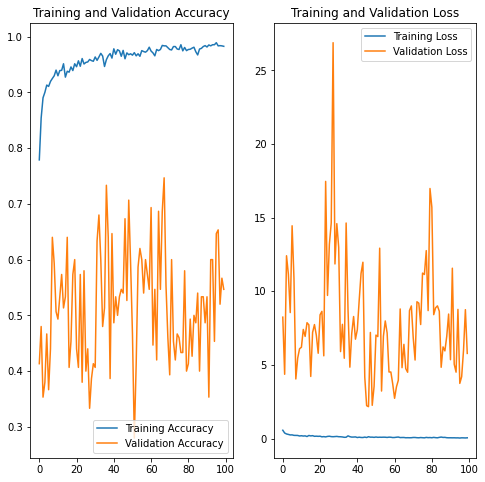

In [360]:
history = fit_model(model)
evaluate_model(history)

MRI Scan #1)


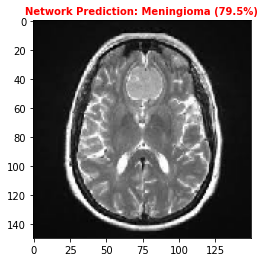

MRI Scan #2)


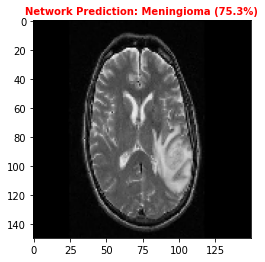

MRI Scan #3)


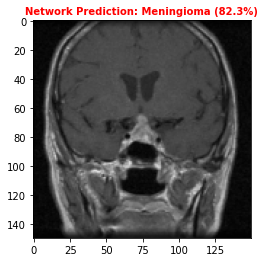

MRI Scan #4)


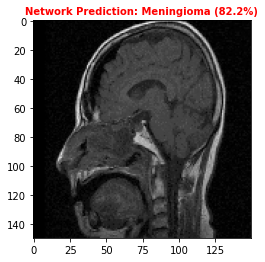

MRI Scan #5)


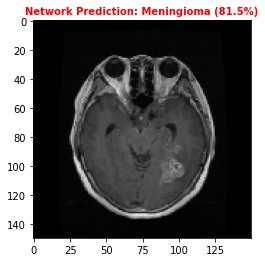

MRI Scan #6)


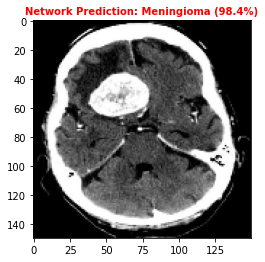

MRI Scan #7)


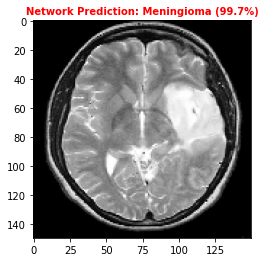

MRI Scan #8)


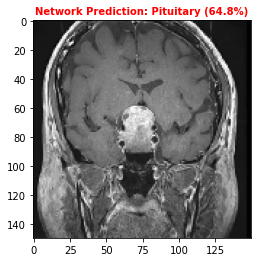

MRI Scan #9)


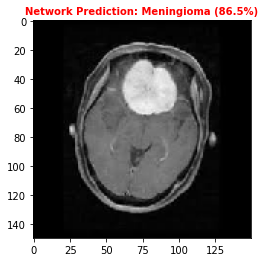

MRI Scan #10)


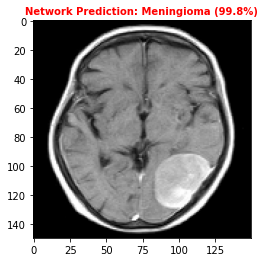

MRI Scan #11)


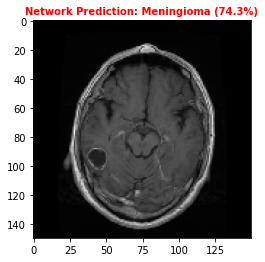

MRI Scan #12)


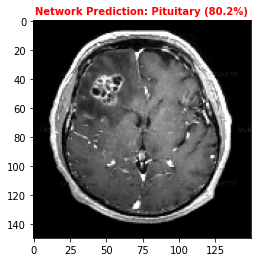

MRI Scan #13)


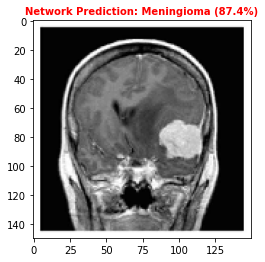

MRI Scan #14)


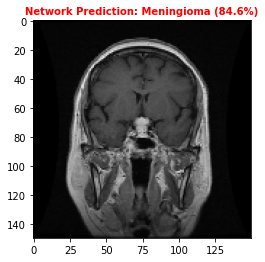

MRI Scan #15)


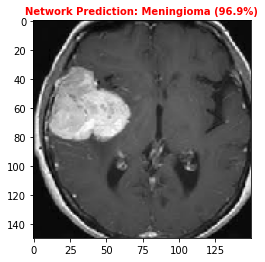

MRI Scan #16)


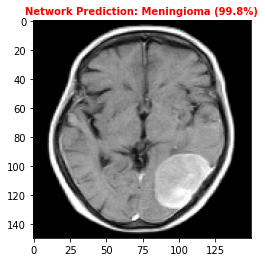

MRI Scan #17)


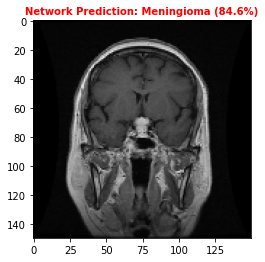

MRI Scan #18)


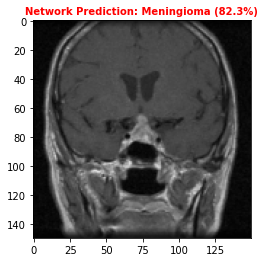

MRI Scan #19)


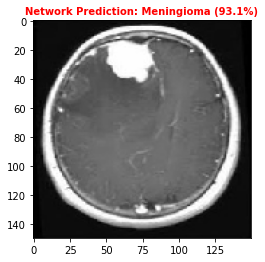

MRI Scan #20)


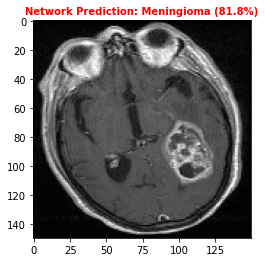

MRI Scan #21)


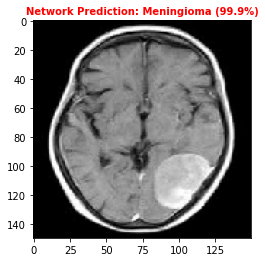

MRI Scan #22)


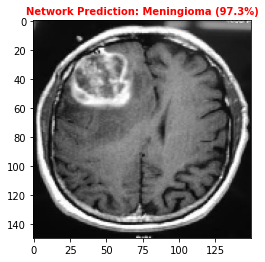

MRI Scan #23)


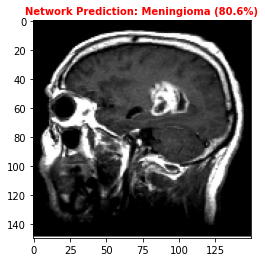

MRI Scan #24)


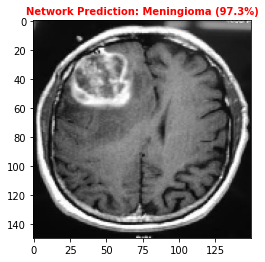

MRI Scan #25)


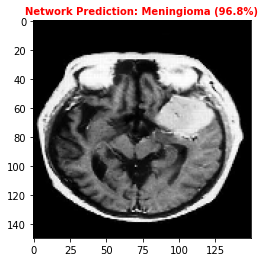

MRI Scan #26)


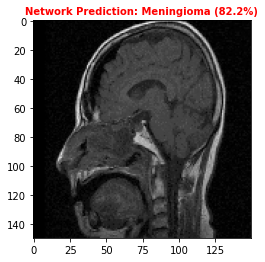

MRI Scan #27)


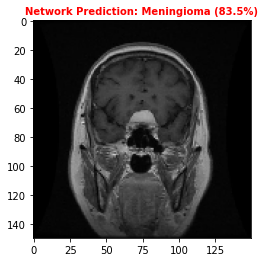

MRI Scan #28)


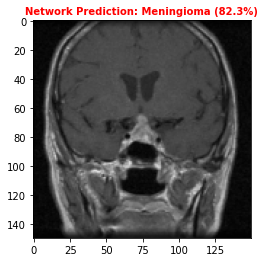

MRI Scan #29)


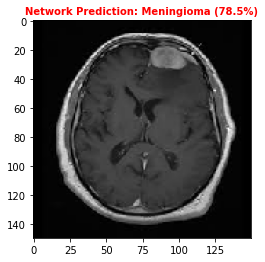

MRI Scan #30)


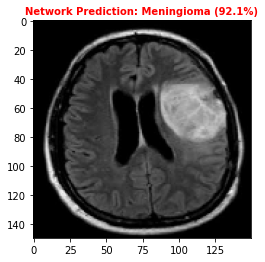

MRI Scan #31)


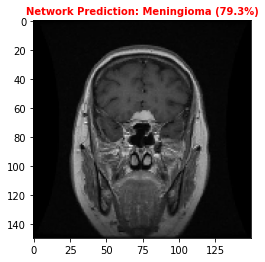

MRI Scan #32)


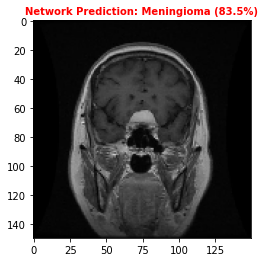

MRI Scan #33)


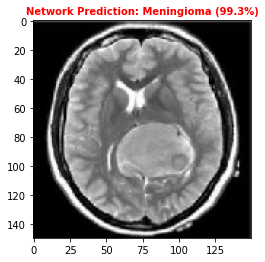

MRI Scan #34)


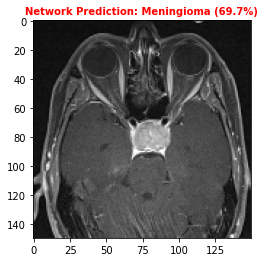

MRI Scan #35)


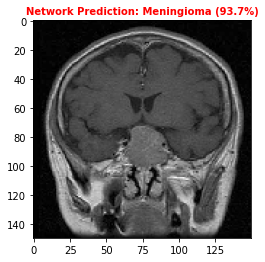

MRI Scan #36)


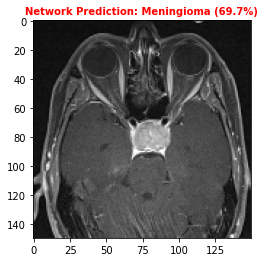

MRI Scan #37)


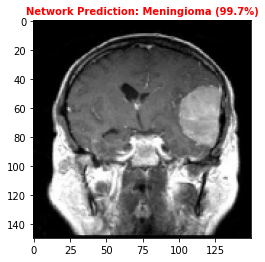

MRI Scan #38)


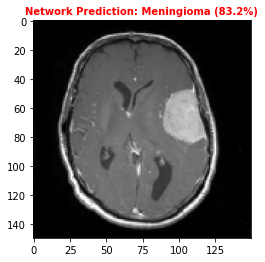

MRI Scan #39)


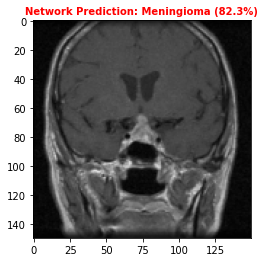

MRI Scan #40)


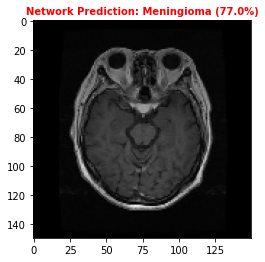

MRI Scan #41)


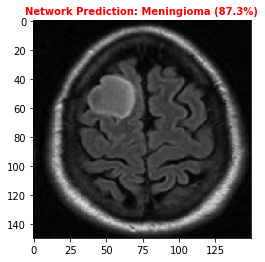

MRI Scan #42)


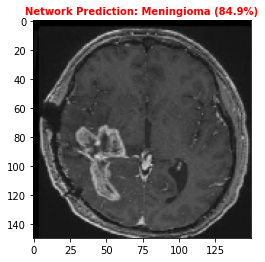

MRI Scan #43)


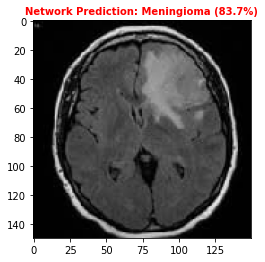

MRI Scan #44)


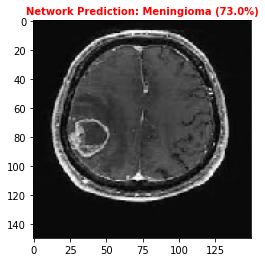

MRI Scan #45)


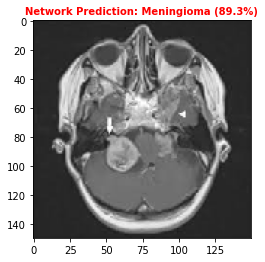

MRI Scan #46)


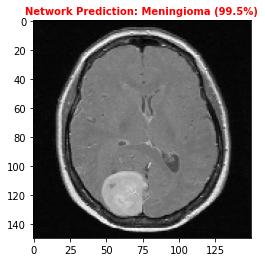

MRI Scan #47)


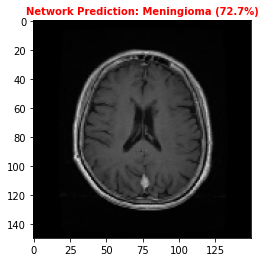

MRI Scan #48)


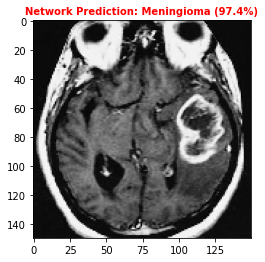

MRI Scan #49)


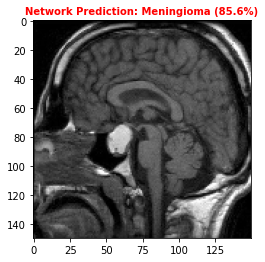

MRI Scan #50)


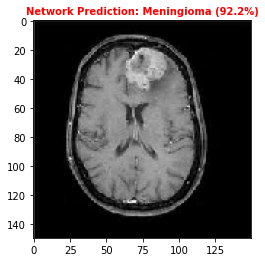

MRI Scan #51)


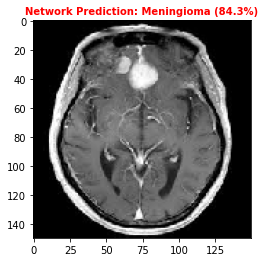

MRI Scan #52)


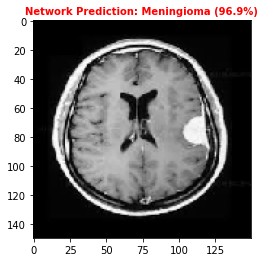

MRI Scan #53)


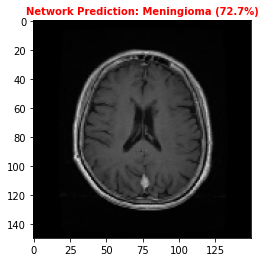

MRI Scan #54)


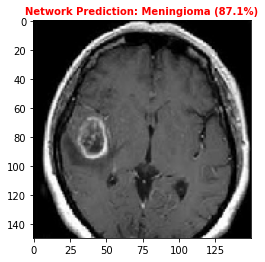

MRI Scan #55)


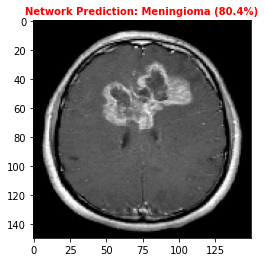

MRI Scan #56)


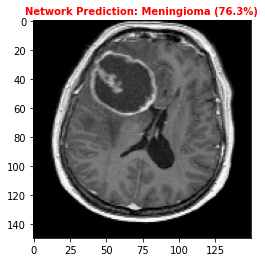

MRI Scan #57)


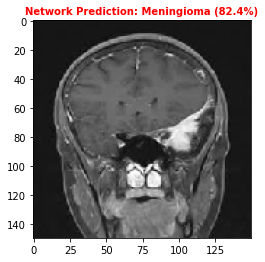

MRI Scan #58)


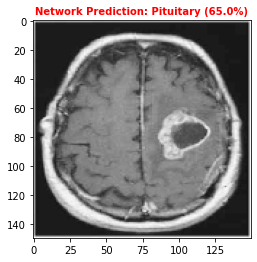

MRI Scan #59)


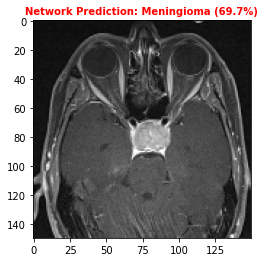

MRI Scan #60)


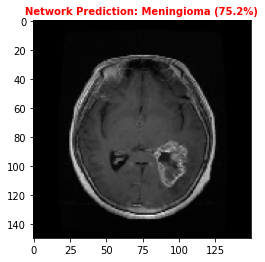

In [361]:
classify_tumor(model, testing_img_paths)